In [59]:
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as plt_patches
import matplotlib.lines as plt_lines

from src.simulation import Simulation
from src.pid import PIDController

# Create Simulation & PID

In [60]:
mass = 0.2
fps = 30
initial_angle = 0.0
initial_velocity = 0.0
initial_position = 0.0
min_angle = -60.0
max_angle = 60.0
max_angle_change = 4.0

simulation = Simulation(
    mass=mass,
    delta_t=1 / fps,
    initial_angle=initial_angle,
    initial_velocity_x=initial_velocity,
    initial_position_x=initial_position,
    min_angle=min_angle,
    max_angle=max_angle,
    max_angle_change=max_angle_change
)

kp = -6.5
ki = -6e-05
kd = -45
initial_setpoint = 0

pid_controller = PIDController(kp, ki, kd, initial_setpoint)

# Create Setpoints

In [76]:
setpoints = [-5] * fps * 3 + [5] * fps * 5 + [0] * fps * 2 + [3] * fps * 2
time = [t / fps for t in range(len(setpoints))]

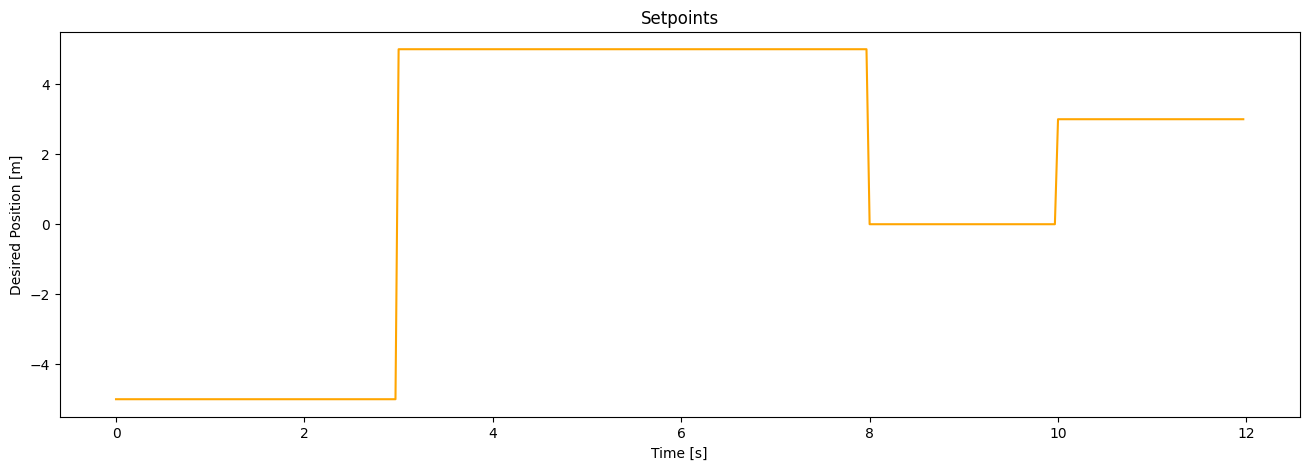

In [77]:
plt.figure(figsize=(16, 5))

plt.plot(time, setpoints, color='orange')
plt.title('Setpoints')
plt.xlabel('Time [s]')
plt.ylabel('Desired Position [m]')

plt.show()

# Run Simulation

In [78]:
errors = deque()
positions = deque()

position = initial_position
for setpoint in setpoints:
    # PID Controller
    pid_controller.setpoint = setpoint
    new_angle = pid_controller.next(position)
    
    # Simulation
    _, _, position = simulation.next(new_angle)
    
    # Collect Data
    errors.append(pid_controller.error)
    positions.append(position)
    
    
pid_controller.reset()
simulation.reset()

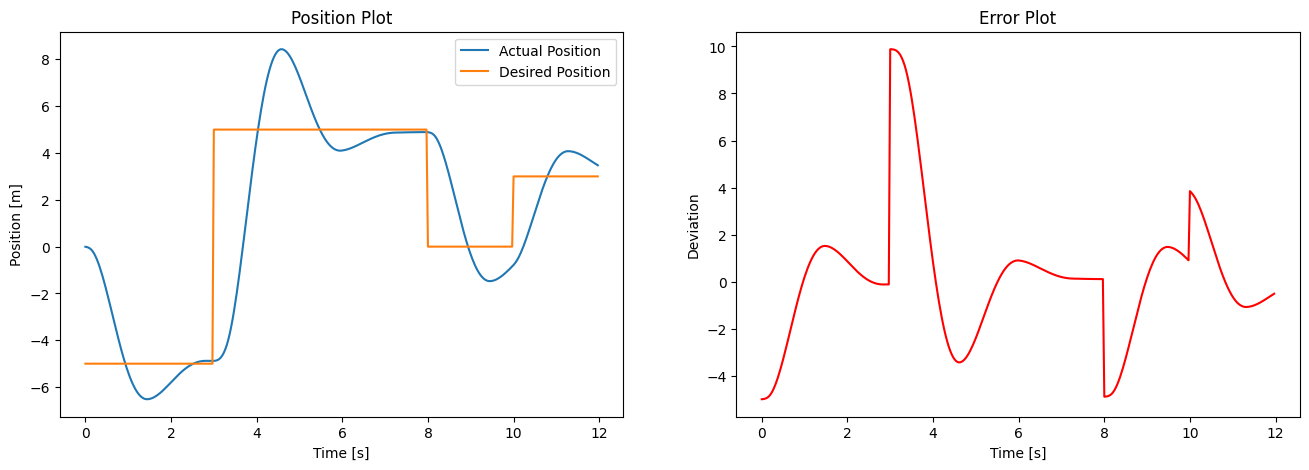

In [79]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

ax[0].plot(time, positions)
ax[0].plot(time, setpoints)
ax[0].set_title('Position Plot')
ax[0].legend(['Actual Position', 'Desired Position'])
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Position [m]')

ax[1].plot(time, errors, 'r')
ax[1].set_title('Error Plot')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Deviation')

plt.show()

# Fitness Function 

In [80]:
# Insert a synthetic 0 in the beginning to ensure the algorithm starts at a setpoint of 0
positions.insert(0, 0)
setpoints.insert(0, 0)

# Adapt Time-Variable for Visualizations
time = [0] + time

### 1) Determine Setpoint Change Positions

In [81]:
setpoints = np.array(setpoints)
setpoint_changes = np.where(np.subtract((setpoints[:-1]), setpoints[1:]) != 0)[0]
setpoint_changes / fps

array([ 0.,  3.,  8., 10.])

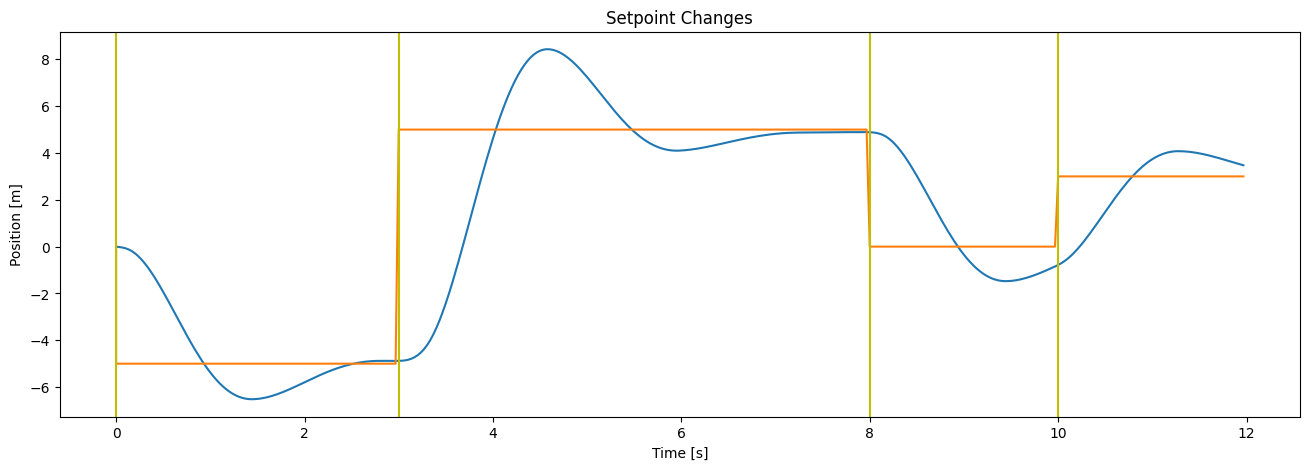

In [82]:
plt.figure(figsize=(16, 5))

plt.plot(time, positions)
plt.plot(time, setpoints)
for setpoint_change in setpoint_changes:
    plt.axvline(x=setpoint_change / fps, color='y')
plt.title('Setpoint Changes')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
    
plt.show()

### 2) Determine Intersection Points between Positions and Setpoint-Function

In [83]:
positions = np.array(positions)
positions_diff = np.diff(positions)
positions_abs_diff = np.abs(positions_diff)
threshold = 0.02

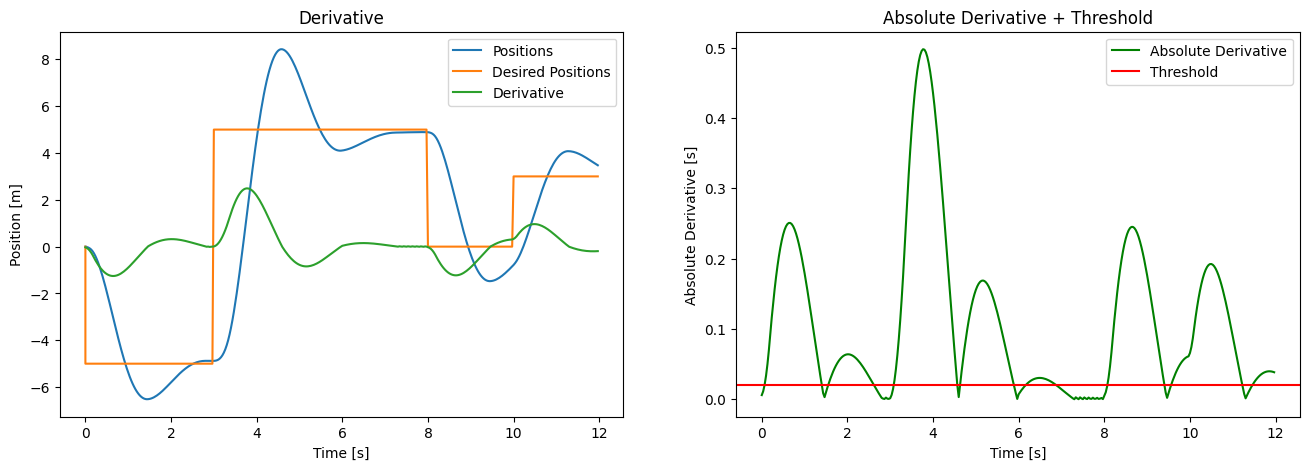

In [84]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

ax[0].plot(time, positions)
ax[0].plot(time, setpoints)
ax[0].plot(time[1:], positions_diff * 5)
ax[0].legend(['Positions', 'Desired Positions', 'Derivative'])
ax[0].set_title('Derivative')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Position [m]')

ax[1].plot(time[1:], positions_abs_diff, color='g')
ax[1].axhline(y=threshold, color='r')
ax[1].legend(['Absolute Derivative', 'Threshold'])
ax[1].set_title('Absolute Derivative + Threshold')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Absolute Derivative [s]')

plt.show()

In [85]:
setpoint_position_difference = setpoints - positions
intersection_points = np.where((np.multiply(setpoint_position_difference[1:], setpoint_position_difference[:-1]) <= 0) & (positions_abs_diff > threshold))[0]
intersection_points / fps

array([ 0.93333333,  2.53333333,  4.03333333,  5.5       ,  8.96666667,
       10.8       ])

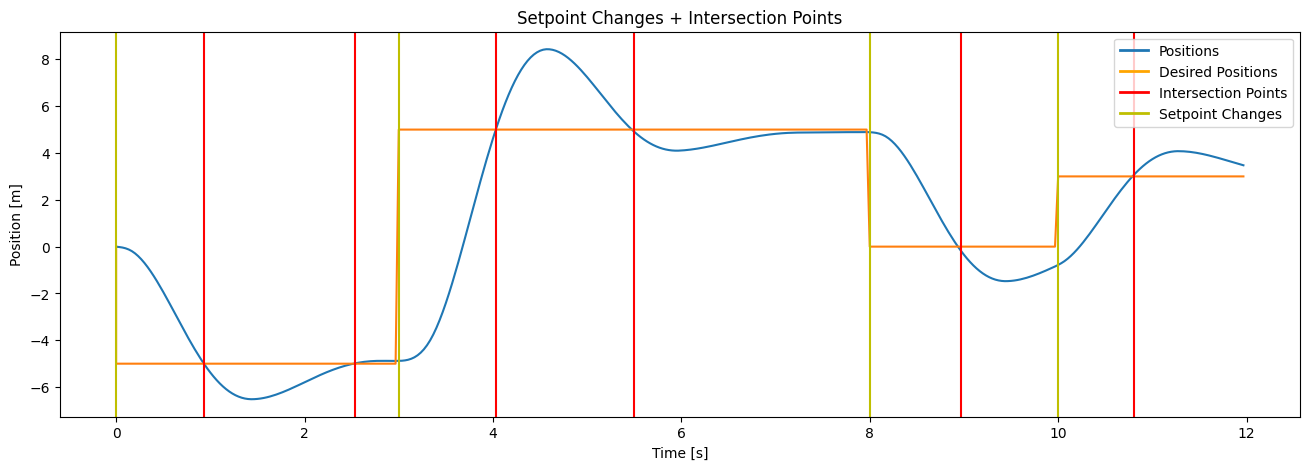

In [86]:
fix, ax = plt.subplots(figsize=(16, 5))

ax.plot(time, positions)
ax.plot(time, setpoints)
for intersection_point in intersection_points:
    ax.axvline(x=intersection_point / fps, color='r')
for setpoint_change in setpoint_changes:
    ax.axvline(x=setpoint_change / fps, color='y')
ax.set_title('Setpoint Changes + Intersection Points')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Position [m]')
legend_handles = [
    plt_lines.Line2D([0], [0], color='#1f77b4', lw=2),
    plt_lines.Line2D([0], [0], color='orange', lw=2),
    plt_lines.Line2D([0], [0], color='r', lw=2),
    plt_lines.Line2D([0], [0], color='y', lw=2),
]
ax.legend(legend_handles, ['Positions', 'Desired Positions', 'Intersection Points', 'Setpoint Changes'])
    
plt.show()

### 3) Distinguish Overshooting Area from Approaching Area

In [87]:
approaching_areas = []
for idx, setpoint_change in enumerate(setpoint_changes):
    next_intersection = next((x for x in intersection_points if x > setpoint_change), None)
    next_setpoint_change = next((x for x in setpoint_changes if x > setpoint_change), None)
    # If there is an intersection following the setpoint change
    if next_intersection is not None:
        # If also a next setpoint change exists take the value which is closer to the current setpoint change
        if next_setpoint_change is not None:
            approaching_areas.append((setpoint_change, next_intersection if next_intersection < next_setpoint_change else next_setpoint_change))
        # Just take the next intersection, if there is no next setpoint change
        else:
            approaching_areas.append((setpoint_change, next_intersection))
    else:
        # If there is no intersection following the setpoint change
        if next_setpoint_change is not None:
            approaching_areas.append((setpoint_change, next_setpoint_change))
        # If there is neither an intersection nor a setpoint change following the setpoint change
        else:
            approaching_areas.append((setpoint_change, len(setpoints) - 1))

approaching_areas

[(0, 28), (90, 121), (240, 269), (300, 324)]

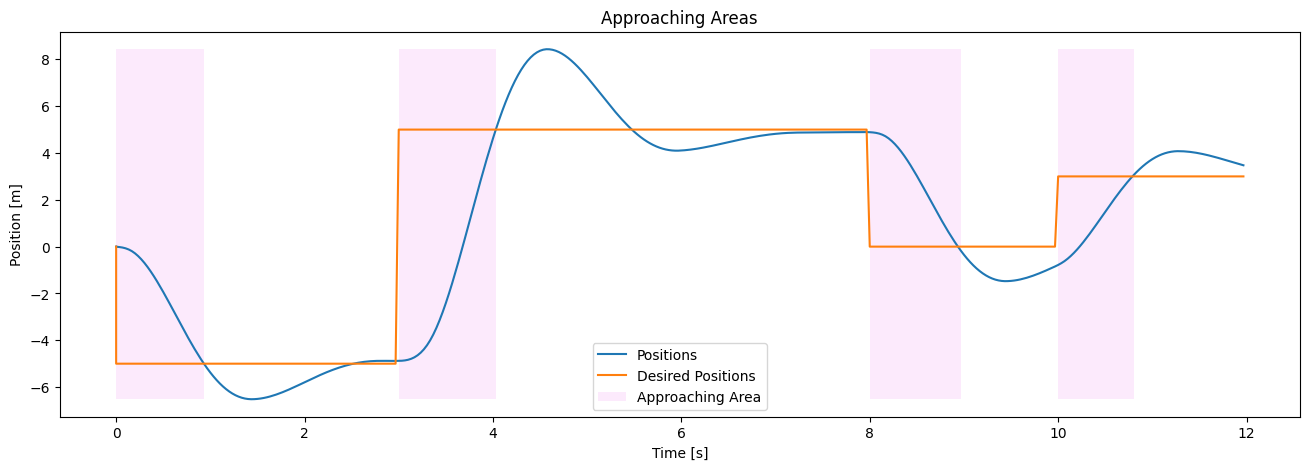

In [88]:
fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(time, positions)
ax.plot(time, setpoints)
for area in approaching_areas:
    ax.add_patch(plt_patches.Rectangle((area[0] / fps, min(positions)), (area[1] - area[0]) / fps, max(positions) - min(positions), facecolor=(.9, .2, .9, 0.1)))
plt.title('Approaching Areas')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.legend(['Positions', 'Desired Positions', 'Approaching Area'])
    
plt.show()

### 4) Create a Weight-Array based on a Factor for the corresponding area

#### Best possible Fitness Value is 0
#### 0 <= Factor < 1: Overshooting leads to bad Fitness
#### Factor > 1: Slow approaching leeds to bad Fitness

In [92]:
approaching_area_importance_factor = 2
assert approaching_area_importance_factor >= 0

error_weights = np.ones(len(setpoints))
for area in approaching_areas:
    error_weights[area[0]:area[1] + 1] = approaching_area_importance_factor
    
error_values = error_weights * np.abs(setpoints - positions)

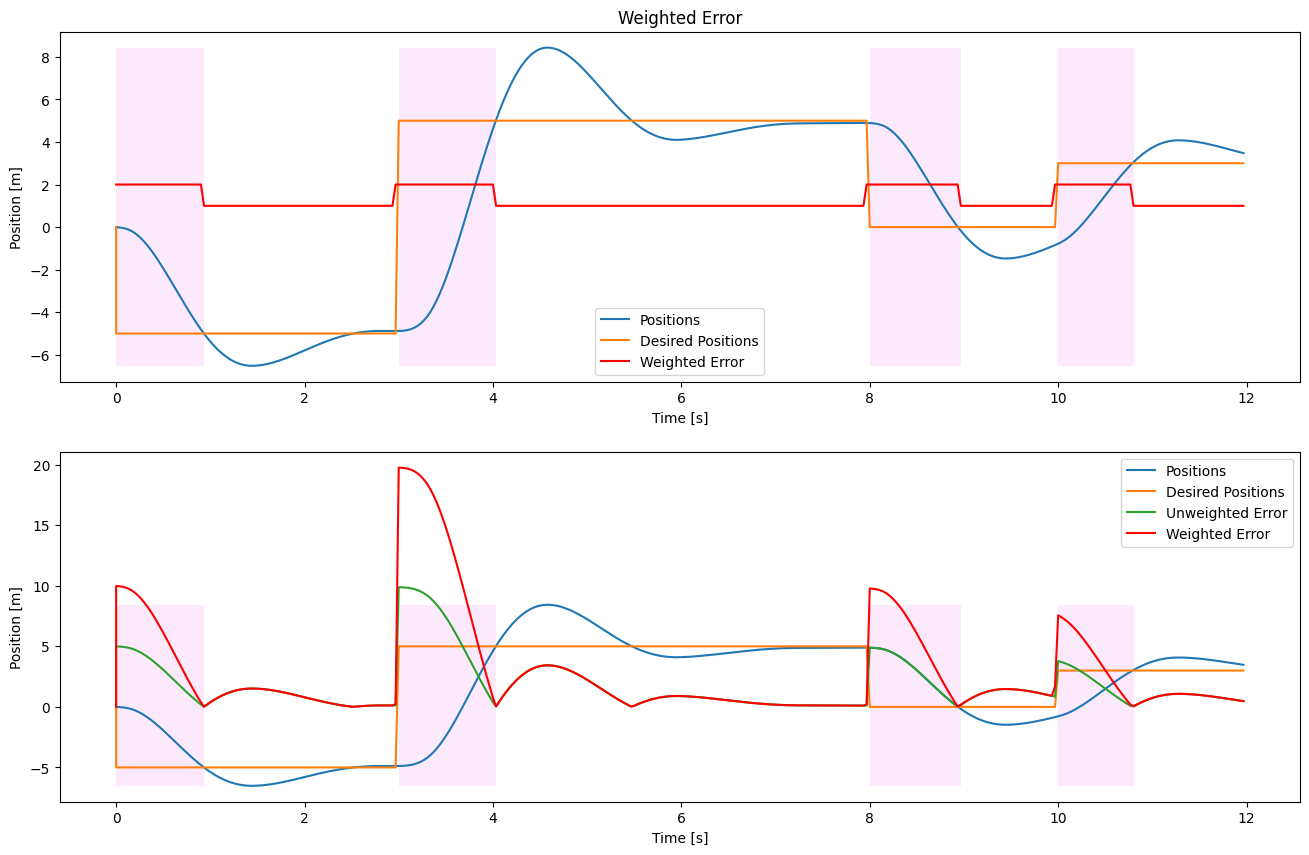

In [93]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))

ax[0].plot(time, positions)
ax[0].plot(time, setpoints)
ax[0].plot(time, error_weights, color='r')
for area in approaching_areas:
    ax[0].add_patch(plt_patches.Rectangle((area[0] / fps, min(positions)), (area[1] - area[0]) / fps, max(positions) - min(positions), facecolor=(.9, .2, .9, 0.1)))
ax[0].set_title('Weighted Error')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Position [m]')
ax[0].legend(['Positions', 'Desired Positions', 'Weighted Error'])

ax[1].plot(time, positions)
ax[1].plot(time, setpoints)
ax[1].plot(time, np.abs(setpoints - positions))
ax[1].plot(time, error_values, color='r')
for area in approaching_areas:
    ax[1].add_patch(plt_patches.Rectangle((area[0] / fps, min(positions)), (area[1] - area[0]) / fps, max(positions) - min(positions), facecolor=(.9, .2, .9, 0.1)))
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Position [m]')
ax[1].legend(['Positions', 'Desired Positions', 'Unweighted Error', 'Weighted Error'])

plt.show()

In [94]:
fitness_value = np.sum(error_values)
fitness_value

1077.6301121004153